In [1]:
import pandas as pd
import datetime
import time
import pandas_datareader.data as web
import math
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 8, 31)

df = web.DataReader("AAPL", "yahoo", start, end)

df.tail()


close_px = df['Adj Close']
mavg = close_px.rolling(window=10).mean()



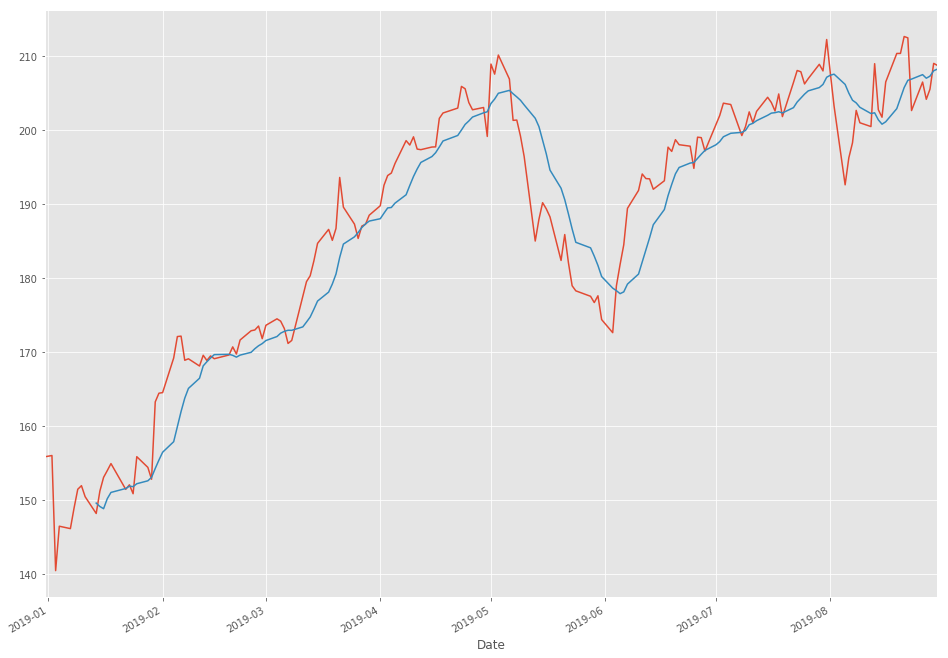

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(16, 12))

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')


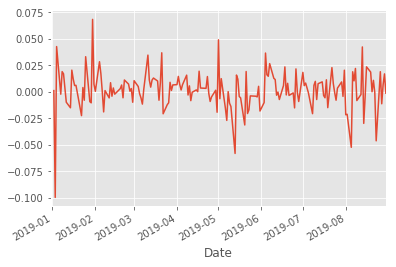

In [3]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [4]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df['Close'] - df['Open']) / df['Open'] * 100.0

print (dfreg)

             Adj Close      Volume    HL_PCT  PCT_change
Date                                                    
2018-12-31  155.871613  35003500.0  1.825792   -0.498324
2019-01-02  156.049484  37039700.0  2.925539    1.956226
2019-01-03  140.505798  91312200.0  2.616219   -1.243224
2019-01-04  146.503891  58607100.0  3.203831    2.580776
2019-01-07  146.177811  54777800.0  1.980672   -0.517824
...                ...         ...       ...         ...
2019-08-26  206.490005  26043600.0  1.031529    0.306036
2019-08-27  204.160004  25873300.0  2.458858   -1.780043
2019-08-28  205.529999  15938800.0  1.167710    0.700633
2019-08-29  209.009995  20990500.0  1.272668    0.244602
2019-08-30  208.740005  21143400.0  1.556961   -0.675675

[169 rows x 4 columns]


### preparing Data

In [5]:
# Drop missing value

dfreg.fillna (value=-99999, inplace=True)

# Separate 1% of the data to forecast

forecast_out = 10

# separate label here
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
      
# Separate label and identify it as y

Y = np.array(dfreg['label'])
Y = Y[:-forecast_out]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)


### Scikit Learn modules


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import Lasso


In [7]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, Y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, Y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, Y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, Y_train)

# Lasso model
clflasso = Lasso()
clflasso.fit(X_train, Y_train)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [8]:
confidencereg = clfreg.score(X_test, Y_test)
confidencepoly2 = clfpoly2.score(X_test, Y_test)
confidencepoly3 = clfpoly3.score(X_test, Y_test)

confidenceknn = clfknn.score(X_test, Y_test)

confidencelasso = clflasso.score(X_test, Y_test)

print ("Confidence : ")
print (" - Linear      : ",confidencereg)
print (" - Poly2 Ridge : ",confidencepoly2)
print (" - Poly3 Ridge : ",confidencepoly3)
print (" - KNN Model   : ", confidenceknn)
print (" - Lasso Model : ", confidencelasso)


Confidence : 
 - Linear      :  0.7036885177142902
 - Poly2 Ridge :  0.7056325466514366
 - Poly3 Ridge :  0.7214640601277467
 - KNN Model   :  0.56455190627835
 - Lasso Model :  0.671314567992825


In [9]:
forecastLinear = clfreg.predict(X_lately)
forecastRidge2 = clfpoly2.predict(X_lately)
forecastRidge3 = clfpoly3.predict(X_lately)
forecastKnn = clfknn.predict(X_lately)
forecastLasso = clflasso.predict(X_lately)

dfreg['Forecast_Linear'] = np.nan
dfreg['Forecast_Ridge2'] = np.nan
dfreg['Forecast_Ridge3'] = np.nan
dfreg['Forecast_Knn'] = np.nan
dfreg['Forecast_Lasso'] = np.nan


last_date = dfreg.iloc[-1].name
last_unix = last_date

# monday to fri only
dayAdd = 1
if last_unix.weekday() > 3:
    dayAdd = 3
    
next_unix = last_unix + datetime.timedelta(days=dayAdd)

for i in range(forecastLinear.size):
    next_date = next_unix
    dayAdd = 1
    if next_unix.weekday() > 3:
        dayAdd = 3
        
    next_unix += datetime.timedelta(days=dayAdd)
    dfreg.loc[next_date] = np.nan 
    dfreg.at[next_date, 'Forecast_Linear'] = forecastLinear[i]
    dfreg.at[next_date, 'Forecast_Ridge2'] =  forecastRidge2[i] 
    dfreg.at[next_date, 'Forecast_Ridge3'] = forecastRidge3[i]
    dfreg.at[next_date, 'Forecast_Knn'] = forecastKnn[i]
    dfreg.at[next_date, 'Forecast_Lasso'] = forecastLasso[i] 



dfreg.tail(20)

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast_Linear,Forecast_Ridge2,Forecast_Ridge3,Forecast_Knn,Forecast_Lasso
Date,,,,,,,,,,
2019-08-19,210.350006,24413600.0,1.283574,-0.128188,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-20,210.360001,26884300.0,1.440387,-0.246588,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-21,212.639999,21535400.0,0.964065,-0.164330,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-22,212.460007,22253700.0,1.736799,-0.342416,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-23,202.639999,46818000.0,5.453022,-3.242130,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-26,206.490005,26043600.0,1.031529,0.306036,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27,204.160004,25873300.0,2.458858,-1.780043,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-28,205.529999,15938800.0,1.167710,0.700633,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-29,209.009995,20990500.0,1.272668,0.244602,NaN,NaN,NaN,NaN,NaN,NaN


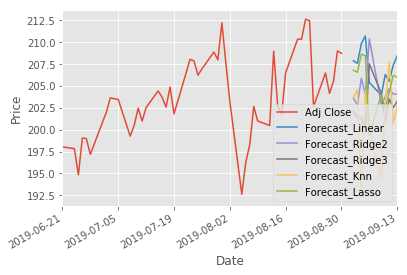

In [10]:

dfreg['Adj Close'].tail(60).plot()
dfreg['Forecast_Linear'].tail(60).plot()
dfreg['Forecast_Ridge2'].tail(60).plot()
dfreg['Forecast_Ridge3'].tail(60).plot()
dfreg['Forecast_Knn'].tail(60).plot()
dfreg['Forecast_Lasso'].tail(60).plot()

plt.rc('figure', figsize=(16, 12))
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



### this is the real result from 03-06 Sep. 

Since 02-sep is holiday, 

So far, Linear and Lasso seems have the best prediction.

Sep 06, 2019	214.05	214.42	212.51	213.26	213.26	19,350,800
Sep 05, 2019	212.00	213.97	211.51	213.28	213.28	23,913,700
Sep 04, 2019	208.39	209.48	207.32	209.19	209.19	19,188,100
Sep 03, 2019	206.43	206.98	204.22	205.70	205.70	20,023,000
